In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [127]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())


train = pd.read_csv("../data/train-290118.csv")
test = pd.read_csv("../data/test_290118.csv")
test_id=test.id

In [128]:
vector = np.vstack((train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values,
                    test[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values))

pca = PCA().fit(vector)
train['vector_pca0'] = pca.transform(train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 0]
test['vector_pca0'] = pca.transform(test[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 0]


In [129]:
dist_features = [x for x in train.columns.tolist() if x.startswith('dist_')]
path_features = [x for x in train.columns.tolist() if x.startswith('path_')]
angle_features = [x for x in train.columns.tolist() if x.startswith('angle_')]
dihedral_features = [x for x in train.columns.tolist() if x.startswith('dihedral_')]
percent_features = [x for x in train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in train.columns.tolist() if x.startswith('avg')]


A_features = [x for x in train.columns.tolist() if x.startswith('A_')]
B_features = [x for x in train.columns.tolist() if x.startswith('B_')]
R_features = [x for x in train.columns.tolist() if x.startswith('R_')]
r_features = [x for x in train.columns.tolist() if x.startswith('r_')]

noatoms_features = [x for x in train.columns.tolist() if x.startswith('number_of_total_atoms_')]
spacegroup_features = [x for x in train.columns.tolist() if x.startswith('spacegroup_')]
lasd_features = [x for x in train.columns.tolist() if x.startswith('lattice_angle_sum_discrete_')]
clusters_features = [x for x in train.columns.tolist() if x.startswith('clusters_')]

In [130]:
features_be = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang',
               'vector_pca0']+avg_features+percent_features+dist_features+A_features+B_features+clusters_features

In [135]:
feature_engineering = ['avg_HOMO',
                         'avg_mass',
                         'avg_IP',
                         'percent_atom_in',
                         'percent_atom_al',
                         'percent_atom_ga',
                         'dist_16',
                         'dist_17',
                         'dist_21',
                         'dist_11',
                         'dist_15',
                         'dist_18',
                         'dist_42',
                         'dist_19',
                         'dist_8',
                         'dist_9',
                         'path_20',
                         'path_40',
                         'path_0',
                         'path_49',
                         'path_30',
                         'path_10',
                         'angle_84',
                         'angle_95',
                         'angle_123',
                         'angle_118',
                         'angle_102',
                         'angle_78',
                         'angle_126',
                         'angle_97',
                         'angle_94',
                         'angle_86',
                         'angle_101',
                         'angle_169',
                         'dihedral_39',
                         'dihedral_130',
                         'dihedral_48',
                         'dihedral_118',
                         'dihedral_89',
                         'dihedral_49',
                         'dihedral_129',
                         'dihedral_76',
                         'dihedral_40',
                         'dihedral_79',
                         'dihedral_29',
                         'dihedral_99',
                         'dihedral_134',
                         'dihedral_2',
                         'dihedral_132',
                         'dihedral_135',
                         'dihedral_20',
                         'dihedral_114',
                         'dihedral_74',
                         'dihedral_107',
                         'A_8',
                         'A_0',
                         'A_2',
                         'A_4',
                         'A_1',
                         'A_5',
                         'A_7',
                         'B_0',
                         'B_8',
                         'B_4',
                         'B_2',
                         'B_1',
                         'B_3',
                         'R_2',
                         'R_1',
                         'R_0',
                         'r_2',
                         'r_0',
                         'r_1',
                         'number_of_total_atoms_30.0',
                         'number_of_total_atoms_40.0',
                         'number_of_total_atoms_80.0',
                         'number_of_total_atoms_60.0',
                         'spacegroup_167',
                         'spacegroup_227',
                         'spacegroup_194',
                         'spacegroup_12',
                         'lattice_angle_sum_discrete_215',
                         'lattice_angle_sum_discrete_270',
                         'lattice_angle_sum_discrete_285',
                         'clusters_3',
                         'clusters_9',
                         'clusters_2',
                         'clusters_1']

In [136]:
X = train[feature_engineering]
Y_be = np.log(train['bandgap_energy_ev']+1)

test = test[feature_engineering]

In [141]:
def runCatBoost(x_train, y_train,x_test, y_test,test,depth):
    model=CatBoostRegressor(iterations=2500,
                            learning_rate=0.01125,#0.01
                            depth=depth,#5
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=99,
                            l2_leaf_reg=14,
                            od_type='Iter',
                            task_type='CPU',
                            od_wait=50)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, logging_level='Silent')
    y_pred_train=model.predict(x_test)
    rmsle_result = rmsle(y_pred_train,y_test)
    y_pred_test=model.predict(test)
    return y_pred_train,rmsle_result,y_pred_test


In [138]:
t = time.time()
cvs = []
kf = model_selection.ShuffleSplit(n_splits=4, test_size=0.25, random_state=30)#.ShuffleSplit(n_splits=10, test_size=.1)#KFold(n_splits=10, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
    y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,dept=14)
    cvs.append(rmsle_feen)

print('this took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs)))

this took 24.00-seconds with a mean validation rmsle of 0.04404 +/- 0.0036782


In [29]:
t = time.time()

rs_dict={}
for rs in range(2,100):
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=4,test_size=1/4, random_state=rs)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=4)
        cvs.append(rmsle_feen)
    rs_dict[rs]=cvs
    print('{3} rs took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), rs))

2 rs took 18.87-seconds with a mean validation rmsle of 0.05345 +/- 0.0034841
3 rs took 37.87-seconds with a mean validation rmsle of 0.04945 +/- 0.0008840
4 rs took 56.52-seconds with a mean validation rmsle of 0.05150 +/- 0.0017523
5 rs took 71.84-seconds with a mean validation rmsle of 0.05059 +/- 0.0009425
6 rs took 92.79-seconds with a mean validation rmsle of 0.04775 +/- 0.0028377
7 rs took 113.23-seconds with a mean validation rmsle of 0.05290 +/- 0.0035160
8 rs took 133.59-seconds with a mean validation rmsle of 0.05341 +/- 0.0021372
9 rs took 148.57-seconds with a mean validation rmsle of 0.05373 +/- 0.0010917
10 rs took 165.32-seconds with a mean validation rmsle of 0.05076 +/- 0.0018259
11 rs took 181.46-seconds with a mean validation rmsle of 0.05077 +/- 0.0005536
12 rs took 196.70-seconds with a mean validation rmsle of 0.05094 +/- 0.0020242
13 rs took 211.31-seconds with a mean validation rmsle of 0.05020 +/- 0.0025516
14 rs took 229.92-seconds with a mean validation rmsl

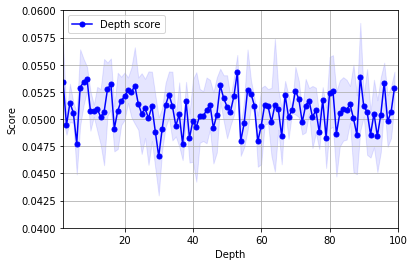

In [30]:
train_mean = np.array([np.mean(x) for x in list(rs_dict.values())])
train_std = np.array([np.std(x) for x in list(rs_dict.values())])

plt.plot(np.arange(2,100), train_mean, color='blue', marker='o', markersize=5, label='Depth score')
plt.fill_between(np.arange(2,100), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.xlim([2, 100])
plt.ylim([0.04, 0.06])
plt.show()

In [ ]:
t = time.time()

strat_shufflesplit_dict={}
for splits in range(2,14):
    cvs = []
    kf = model_selection.StratifiedShuffleSplit(n_splits=splits,test_size=1/splits, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,lr=0.015)
        cvs.append(rmsle_feen)
    strat_shufflesplit_dict[splits]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), splits))

train_mean = np.array([np.mean(x) for x in list(strat_shufflesplit_dict.values())])
train_std = np.array([np.std(x) for x in list(strat_shufflesplit_dict.values())])

plt.plot(np.arange(2,14), train_mean, color='blue', marker='o', markersize=5, label='Depth score')
plt.fill_between(np.arange(2,14), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.xlim([2, 13])
plt.ylim([0.04, 0.06])
plt.show()

In [ ]:
t = time.time()

depth_dict={}
for lr in np.linspace(0.001,0.1,100):
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=4,test_size=0.25, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,lr=lr)
        cvs.append(rmsle_feen)
    depth_dict[lr]=cvs
    print('this learning rate of {} took {}-seconds with a mean validation rmsle of {} +/- {}'.format(lr, time.time()-t, np.mean(cvs), np.std(cvs)))

this learning rate of 0.001 took 16.11655855178833-seconds with a mean validation rmsle of 0.07883281182137324 +/- 0.004636367026110118
this learning rate of 0.002 took 32.2201623916626-seconds with a mean validation rmsle of 0.05252390026941388 +/- 0.005214539461877526
this learning rate of 0.003 took 48.36822056770325-seconds with a mean validation rmsle of 0.0493688543887324 +/- 0.004182027932939966
this learning rate of 0.004 took 64.50320863723755-seconds with a mean validation rmsle of 0.048248564897363774 +/- 0.003807432198462839
this learning rate of 0.005 took 80.48487257957458-seconds with a mean validation rmsle of 0.04757173408083947 +/- 0.003552566052946774
this learning rate of 0.006 took 96.55066323280334-seconds with a mean validation rmsle of 0.04722827120647333 +/- 0.0034976625223175624
this learning rate of 0.007 took 112.35887956619263-seconds with a mean validation rmsle of 0.046882791355987885 +/- 0.0034121718597998627
this learning rate of 0.008 took 128.03884458

In [146]:
depth_dict[np.linspace(0.001,0.1,100)[11]]

[0.045470597115431784,
 0.047402864304309802,
 0.051606912089555604,
 0.041951429214263758]

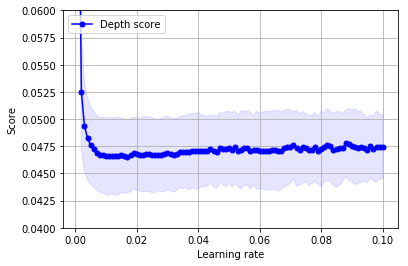

In [136]:
train_mean = np.array([np.mean(x) for x in list(depth_dict.values())])
train_std = np.array([np.std(x) for x in list(depth_dict.values())])

plt.plot(np.linspace(0.001,0.1,100), train_mean, color='blue', marker='o', markersize=5, label='Depth score')
plt.fill_between(np.linspace(0.001,0.1,100), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.ylim([0.04, 0.06])
plt.show()

2 splits took 19.08-seconds with a mean validation rmsle of 0.04474 +/- 0.0035952
3 splits took 39.25-seconds with a mean validation rmsle of 0.04443 +/- 0.0035317
4 splits took 56.66-seconds with a mean validation rmsle of 0.04457 +/- 0.0036534
5 splits took 77.10-seconds with a mean validation rmsle of 0.04442 +/- 0.0037609
6 splits took 99.33-seconds with a mean validation rmsle of 0.04437 +/- 0.0036392
7 splits took 121.60-seconds with a mean validation rmsle of 0.04426 +/- 0.0037783
8 splits took 143.33-seconds with a mean validation rmsle of 0.04428 +/- 0.0037474
9 splits took 166.50-seconds with a mean validation rmsle of 0.04407 +/- 0.0037627
10 splits took 190.21-seconds with a mean validation rmsle of 0.04413 +/- 0.0038945
11 splits took 212.91-seconds with a mean validation rmsle of 0.04413 +/- 0.0036559
12 splits took 235.54-seconds with a mean validation rmsle of 0.04420 +/- 0.0037790
13 splits took 257.41-seconds with a mean validation rmsle of 0.04415 +/- 0.0037447
14 sp

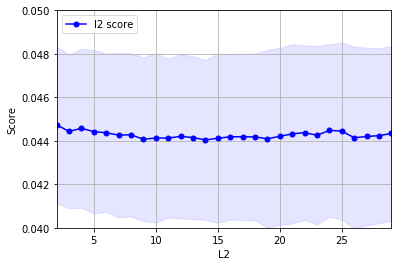

In [105]:
t = time.time()

l2_dict={}
for l2 in range(2,30):
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=4, test_size=0.25, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,l2reg=l2)
        cvs.append(rmsle_feen)
    l2_dict[l2]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), l2))


train_mean = np.array([np.mean(x) for x in list(l2_dict.values())])
train_std = np.array([np.std(x) for x in list(l2_dict.values())])

plt.plot(np.arange(2,30), train_mean, color='blue', marker='o', markersize=5, label='l2 score')
plt.fill_between(np.arange(2,30), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('L2')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.xlim([2, 29])
plt.ylim([0.04, 0.05])
plt.show()

In [140]:
t = time.time()

depth_dict={}
for depth in range(2,17):
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=4, test_size=0.25, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=depth)
        cvs.append(rmsle_feen)
    depth_dict[depth]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), depth))


TypeError: runCatBoost() got an unexpected keyword argument 'depth'

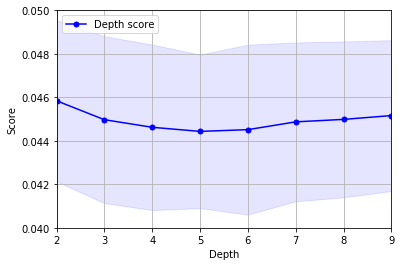

In [45]:
train_mean = np.array([np.mean(x) for x in list(depth_dict.values())])
train_std = np.array([np.std(x) for x in list(depth_dict.values())])

plt.plot(np.arange(2,10), train_mean, color='blue', marker='o', markersize=5, label='Depth score')
plt.fill_between(np.arange(2,10), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('Depth')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.xlim([2, 9])
plt.ylim([0.04, 0.05])
plt.show()

In [49]:
t = time.time()

kfold_dict={}
for splits in range(2,13):
    cvs = []
    kf = model_selection.KFold(n_splits=splits, shuffle=True, random_state=30)#.ShuffleSplit(n_splits=10, test_size=.1)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=5)
        cvs.append(rmsle_feen)
    kfold_dict[splits]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), splits))

2 splits took 8.25-seconds with a mean validation rmsle of 0.04918 +/- 0.0005549
3 splits took 20.54-seconds with a mean validation rmsle of 0.04955 +/- 0.0027129
4 splits took 38.21-seconds with a mean validation rmsle of 0.04869 +/- 0.0051457
5 splits took 61.99-seconds with a mean validation rmsle of 0.04801 +/- 0.0048429
6 splits took 84.89-seconds with a mean validation rmsle of 0.04904 +/- 0.0052281
7 splits took 112.57-seconds with a mean validation rmsle of 0.04892 +/- 0.0062697
8 splits took 148.58-seconds with a mean validation rmsle of 0.04827 +/- 0.0067682
9 splits took 182.98-seconds with a mean validation rmsle of 0.04859 +/- 0.0050335
10 splits took 219.05-seconds with a mean validation rmsle of 0.04882 +/- 0.0051473
11 splits took 262.78-seconds with a mean validation rmsle of 0.04819 +/- 0.0050951
12 splits took 312.76-seconds with a mean validation rmsle of 0.04815 +/- 0.0072661


In [75]:
t = time.time()

depth_dict_shuffle={}
for splits in range(2,13):
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=splits, test_size=1/splits, random_state=30)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=5)
        cvs.append(rmsle_feen)
    depth_dict_shuffle[splits]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), splits))

2 splits took 10.15-seconds with a mean validation rmsle of 0.04898 +/- 0.0008795
3 splits took 24.02-seconds with a mean validation rmsle of 0.04833 +/- 0.0006656
4 splits took 44.73-seconds with a mean validation rmsle of 0.04443 +/- 0.0035317
5 splits took 67.66-seconds with a mean validation rmsle of 0.04580 +/- 0.0043318
6 splits took 94.81-seconds with a mean validation rmsle of 0.04613 +/- 0.0043504
7 splits took 123.30-seconds with a mean validation rmsle of 0.04664 +/- 0.0051933
8 splits took 161.51-seconds with a mean validation rmsle of 0.04683 +/- 0.0045413
9 splits took 197.68-seconds with a mean validation rmsle of 0.04602 +/- 0.0056792
10 splits took 241.69-seconds with a mean validation rmsle of 0.04714 +/- 0.0070135
11 splits took 283.60-seconds with a mean validation rmsle of 0.04627 +/- 0.0064298
12 splits took 337.17-seconds with a mean validation rmsle of 0.04507 +/- 0.0067212


In [87]:
t = time.time()

depth_dict_stra_shuffle={}
for splits in range(2,13):
    cvs = []
    kf = model_selection.StratifiedShuffleSplit(n_splits=splits, test_size=1/splits, random_state=30)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X,train['clusters'].values):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=5)
        cvs.append(rmsle_feen)
    depth_dict_stra_shuffle[splits]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), splits))

2 splits took 7.42-seconds with a mean validation rmsle of 0.05156 +/- 0.0015365
3 splits took 18.88-seconds with a mean validation rmsle of 0.04976 +/- 0.0017771
4 splits took 36.16-seconds with a mean validation rmsle of 0.04705 +/- 0.0028457
5 splits took 60.27-seconds with a mean validation rmsle of 0.04655 +/- 0.0037244
6 splits took 85.68-seconds with a mean validation rmsle of 0.04562 +/- 0.0042791
7 splits took 117.36-seconds with a mean validation rmsle of 0.04981 +/- 0.0042186
8 splits took 154.94-seconds with a mean validation rmsle of 0.04532 +/- 0.0039829
9 splits took 194.07-seconds with a mean validation rmsle of 0.04812 +/- 0.0036247
10 splits took 239.72-seconds with a mean validation rmsle of 0.04641 +/- 0.0045850
11 splits took 285.68-seconds with a mean validation rmsle of 0.04603 +/- 0.0053561
12 splits took 337.29-seconds with a mean validation rmsle of 0.04926 +/- 0.0066096


In [89]:
t = time.time()

depth_dict_stra_kfold={}
for splits in range(2,13):
    cvs = []
    kf = model_selection.StratifiedKFold(n_splits=splits, random_state=30)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X,train['clusters'].values):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_be.loc[dev_index], Y_be.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=5)
        cvs.append(rmsle_feen)
    depth_dict_stra_kfold[splits]=cvs
    print('{3} splits took {0:.02f}-seconds with a mean validation rmsle of {1:0.5f} +/- {2:0.7f}'.format(time.time()-t, np.mean(cvs), np.std(cvs), splits))

2 splits took 6.53-seconds with a mean validation rmsle of 0.04943 +/- 0.0018493
3 splits took 20.49-seconds with a mean validation rmsle of 0.04848 +/- 0.0016825
4 splits took 36.44-seconds with a mean validation rmsle of 0.04890 +/- 0.0027708
5 splits took 57.36-seconds with a mean validation rmsle of 0.04898 +/- 0.0026448
6 splits took 81.48-seconds with a mean validation rmsle of 0.04873 +/- 0.0016690
7 splits took 110.40-seconds with a mean validation rmsle of 0.04899 +/- 0.0030531
8 splits took 146.27-seconds with a mean validation rmsle of 0.04848 +/- 0.0049897
9 splits took 182.76-seconds with a mean validation rmsle of 0.04784 +/- 0.0049918
10 splits took 222.88-seconds with a mean validation rmsle of 0.04860 +/- 0.0040759
11 splits took 264.07-seconds with a mean validation rmsle of 0.04860 +/- 0.0043396
12 splits took 308.45-seconds with a mean validation rmsle of 0.04830 +/- 0.0047725


In [98]:
len(train_mean_strat_shuffle)

11

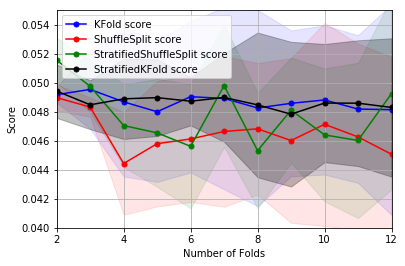

In [101]:
train_mean = np.array([np.mean(x) for x in list(kfold_dict.values())])
train_std = np.array([np.std(x) for x in list(kfold_dict.values())])

train_mean_s = np.array([np.mean(x) for x in list(depth_dict_shuffle.values())])
train_std_s = np.array([np.std(x) for x in list(depth_dict_shuffle.values())])

train_mean_strat_shuffle = np.array([np.mean(x) for x in list(depth_dict_stra_shuffle.values())])
train_std_s_strat_shuffle = np.array([np.std(x) for x in list(depth_dict_stra_shuffle.values())])

train_mean_strat_kfold = np.array([np.mean(x) for x in list(depth_dict_stra_kfold.values())])
train_std_s_strat_kfold = np.array([np.std(x) for x in list(depth_dict_stra_kfold.values())])


plt.plot(np.arange(2,13), train_mean, color='blue', marker='o', markersize=5, label='KFold score')
plt.fill_between(np.arange(2,13), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.plot(np.arange(2,13), train_mean_s, color='red', marker='o', markersize=5, label='ShuffleSplit score')
plt.fill_between(np.arange(2,13), train_mean_s + train_std_s, train_mean_s - train_std_s, alpha=.1, color='red')

plt.plot(np.arange(2,13), train_mean_strat_shuffle, color='green', marker='o', markersize=5, label='StratifiedShuffleSplit score')
plt.fill_between(np.arange(2,13), train_mean_strat_shuffle + train_std_s_strat_shuffle, train_mean_strat_shuffle - train_std_s_strat_shuffle, alpha=.1, color='green')

plt.plot(np.arange(2,13), train_mean_strat_kfold, color='black', marker='o', markersize=5, label='StratifiedKFold score')
plt.fill_between(np.arange(2,13), train_mean_strat_kfold + train_std_s_strat_kfold, train_mean_strat_kfold - train_std_s_strat_kfold, alpha=.25, color='black')

plt.grid()

plt.xlabel('Number of Folds')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.xlim([2, 12])
plt.ylim([0.04, 0.055])
plt.show()

In [ ]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_bee.loc[dev_index], Y_bee.loc[val_index]
    y_pred_bee,rmsle_bee,y_pred_test_bee=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=4)
print("Mean cv score : ", np.mean(rmsle_bee))

In [ ]:
sub=pd.DataFrame()
sub["id"]=test_id
sub["formation_energy_ev_natom"]=np.exp(y_pred_test_feen)-1
sub["bandgap_energy_ev"]=np.exp(y_pred_test_bee)-1
rmsle_total=np.mean([rmsle_bee,rmsle_feen])
print(rmsle_total)
sub.to_csv(str(rmsle_total)+"_.csv",index=False)